# Basic CNN in Tensorflow

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [127]:
test_data_og = np.load('../test-processed/test_x_l2a_processed.npy')
test_labels_og = np.load('../test-processed/test_y_l2a_processed.npy')
test_length = np.load('../test-processed/test_length_l2a_processed.npy')
train_data_og = np.load('../train-processed/data_x_l2a_processed.npy')
train_labels_og= np.load('../train-processed/data_y_l2a_processed.npy')
train_length = np.load('../train-processed/length_l2a_processed.npy')

In [34]:
# The X data channels are as below:
# [B02,B03,B04,B05,B06,B07, B08, B8A,B11,B12, SLOPE, EVI, MSAVI2, Bare soil index, Sentinel 1 VV, Sentinel 1 VH]

test_data.shape

(684, 24, 16, 16, 17)

## Visualizing the different bands 

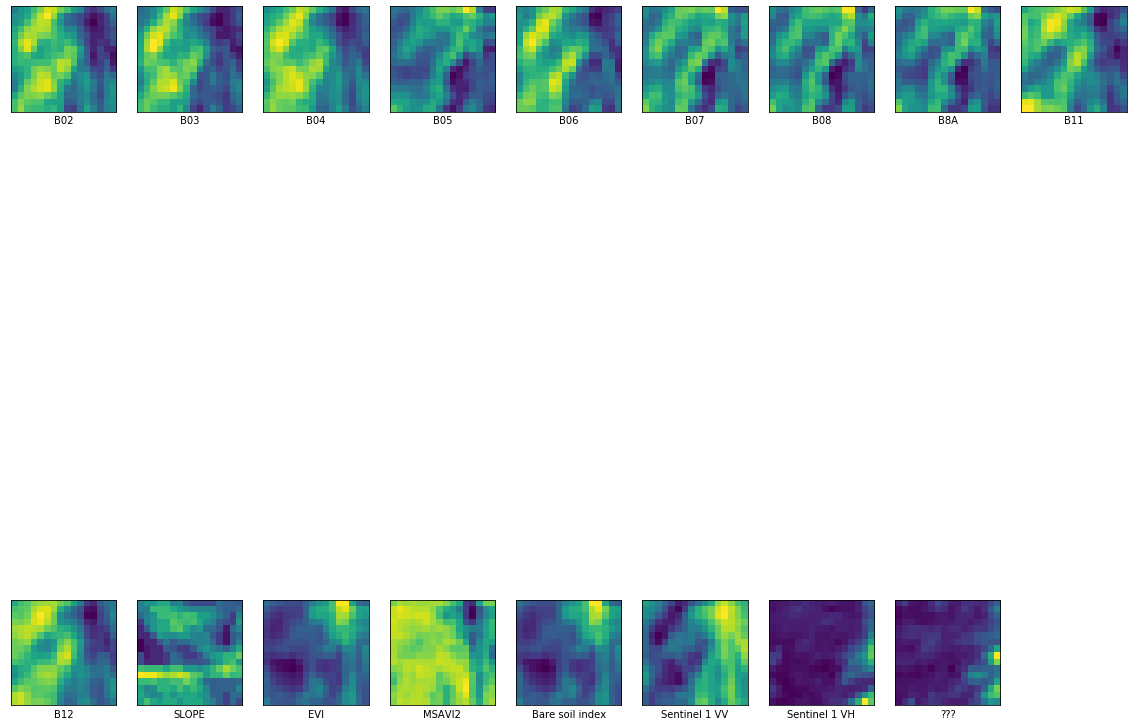

In [62]:
band_names = ['B02',"B03",'B04','B05','B06','B07', 'B08', 'B8A','B11','B12', 
              'SLOPE','EVI', 'MSAVI2', 'Bare soil index', 'Sentinel 1 VV', 'Sentinel 1 VH', '???']

plt.figure(figsize=(20,20))
for i in range(17):
    plt.subplot(2,9,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_data[0,0,:,:,i])
    plt.xlabel(band_names[i])
plt.show()

### Cleaning up the data

**Removing erroneous column 14**

In [144]:
# column 14 contains NaN-s
nan = np.isnan(test_data[:,:,:,:,14])

unique_elements, counts_elements = np.unique(nan, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[      0       1]
 [4201728     768]]


In [135]:
# removing column 14 as it has NaN-s
test_data2 = np.delete(test_data_og,14, axis = 4)
train_data2 = np.delete(train_data_og,14, axis = 4)

In [136]:
train_data2.shape

(4383, 24, 16, 16, 16)

In [140]:
nan = np.isnan(test_data2[:,:,:,:,14])

unique_elements, counts_elements = np.unique(nan, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[      0]
 [4202496]]


**Simplifying to a single time dimension**

In [141]:
train_data3 = train_data2[:,23,:,:,:]
train_data3.shape

(4383, 16, 16, 16)

In [143]:
test_data3 = test_data2[:,23,:,:,:]
test_data3.shape

(684, 16, 16, 16)

**Normalize data [x_norm = (x - min) / (max - min)]**

In [157]:
data = np.concatenate((train_data3, test_data3), axis = 0)

# calculating the minimums and the max-min by column 
minarray = np.min(data, axis = (0,1,2))
max_min_array = np.max(data, axis = (0,1,2)) - np.min(data, axis = (0,1,2))

# reshaping into the size of our data
min_4d = np.tile(minarray, 4383*16*16).reshape(4383,16,16,16)
max_min_4d = np.tile(max_min_array, 4383*16*16).reshape(4383,16,16,16)


train_data4 = (train_data3 - minarray) / max_min_array
test_data4 = (test_data3 - minarray) / max_min_array


In [158]:
# setting it to the original name
train_data = train_data4
test_data = test_data4

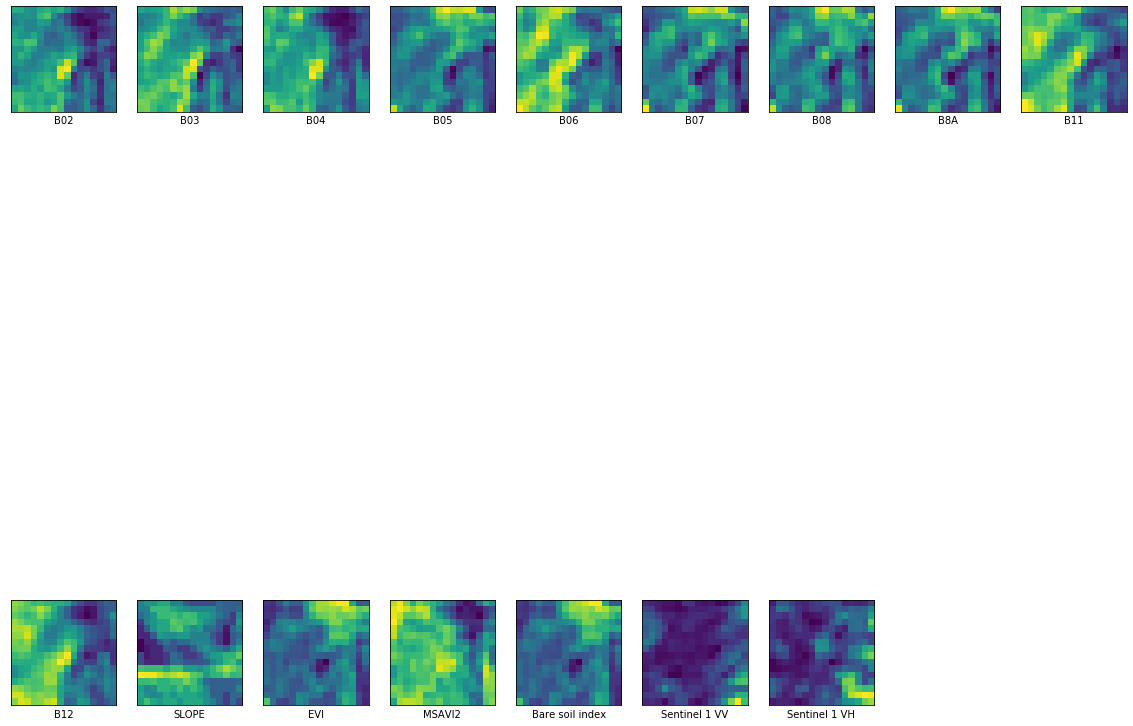

In [160]:
# Visualization at time 24 as chosen above
band_names = ['B02',"B03",'B04','B05','B06','B07', 'B08', 'B8A','B11','B12', 
              'SLOPE','EVI', 'MSAVI2', 'Bare soil index', 'Sentinel 1 VV', 'Sentinel 1 VH']

plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(2,9,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_data[0,:,:,i])
    plt.xlabel(band_names[i])
plt.show()

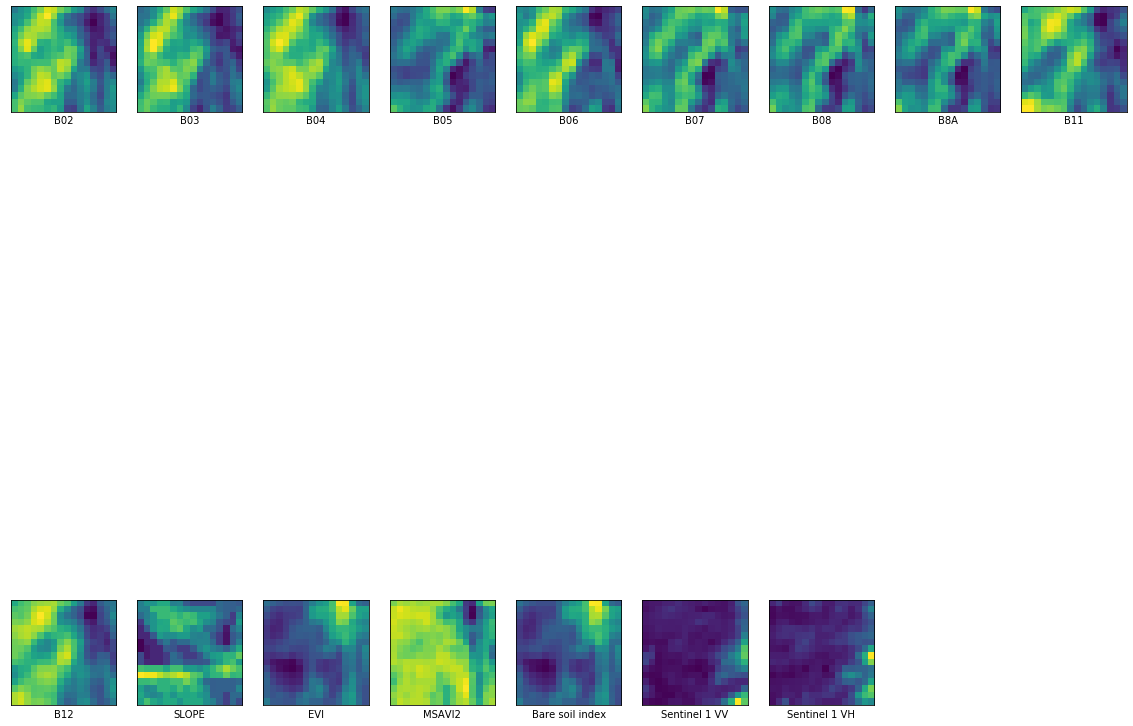

In [162]:
# Visualization at time 0
band_names = ['B02',"B03",'B04','B05','B06','B07', 'B08', 'B8A','B11','B12', 
              'SLOPE','EVI', 'MSAVI2', 'Bare soil index', 'Sentinel 1 VV', 'Sentinel 1 VH']

plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(2,9,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_data2[0,0,:,:,i])
    plt.xlabel(band_names[i])
plt.show()

/Users/danielcsonth/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


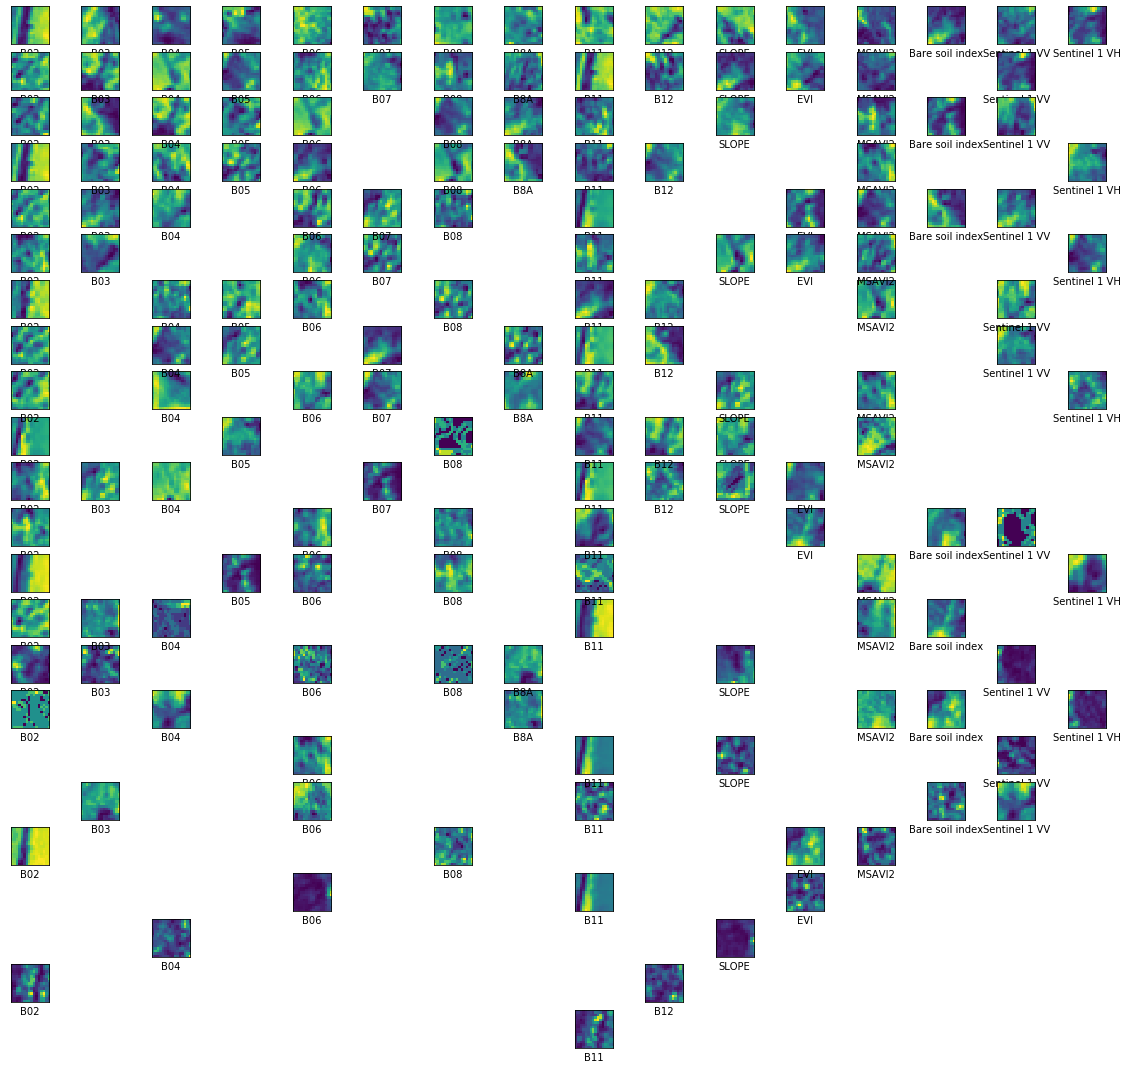

In [170]:
# trying to show each image's evolution over time, but for some reason not all images show up... (?)
band_names = ['B02',"B03",'B04','B05','B06','B07', 'B08', 'B8A','B11','B12', 
              'SLOPE','EVI', 'MSAVI2', 'Bare soil index', 'Sentinel 1 VV', 'Sentinel 1 VH']

plt.figure(figsize=(20,20))
for t in range(24):
    for b in range(16):
        plt.subplot(24,16,t*b+b+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_data2[t,0,:,:,b])
        plt.xlabel(band_names[(t*b+b) % 16])
plt.show()

**Visualizing the classification**

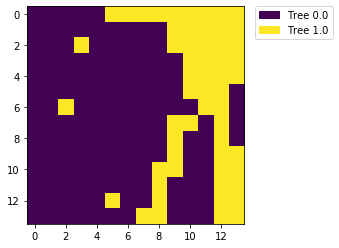

In [171]:
import matplotlib.patches as mpatches

im = plt.imshow(test_label[0])
values = np.unique(test_label[0].ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Tree {l}".format(l=values[i]) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )



## Building the model in Keras

In [130]:
model = models.Sequential()
model.add(layers.Conv2D(20, (3, 3), activation='relu', input_shape=(14, 14, 17)))
model.add(layers.Conv2D(40, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dense(196, activation='sigmoid'))

In [131]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 12, 12, 20)        3080      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 20)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 40)          7240      
_________________________________________________________________
flatten_3 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 40)                25640     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 41        
Total params: 36,001
Trainable params: 36,001
Non-trainable params: 0
__________________________________________________

In [132]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data3, train_labels, epochs=10, 
                    validation_data=(test_data3, test_labels))

ValueError: Error when checking input: expected conv2d_17_input to have 4 dimensions, but got array with shape (4383, 24, 14, 14, 16)

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)